In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import itertools

In [2]:
# Mengimpor data penjualan
data = "https://raw.githubusercontent.com/indescared/otwsarjana/main/data%20penjualan.xlsx"
df = pd.read_excel(data)
df['tanggal'] = pd.to_datetime(df['tanggal'])
df.set_index('tanggal', inplace=True)

In [3]:
# Memeriksa data
print(df.head())
print(df.describe())
print(df.isnull().sum())

            volume penjualan
tanggal                     
2021-01-01                 2
2021-01-02                 1
2021-01-04                10
2021-01-05                 5
2021-01-06                 9
       volume penjualan
count       1374.000000
mean          58.850073
std           43.187451
min            1.000000
25%           29.000000
50%           56.000000
75%           79.750000
max          345.000000
volume penjualan    0
dtype: int64


In [4]:
# Prepare data
values = df['volume penjualan'].values.reshape(-1, 1)

In [5]:
# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

In [6]:
# Splitting data into train and test sets
train_size = int(len(scaled_values) * 0.8)
train_data = scaled_values[:train_size]
test_data = scaled_values[train_size:]

In [7]:
# Create sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [8]:
# Hyperparameter combinations
time_steps = 10
epochs_list = [20, 50, 100]
batch_sizes = [16, 32, 64]
units_list = [32, 64, 128]

In [9]:
# Create sequences for current time_steps
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

In [10]:
# Adjust y_train and y_test dimensions
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [11]:
# Store results
results = []

In [12]:
# Grid search over hyperparameters
for epochs, batch_size, units in itertools.product(epochs_list, batch_sizes, units_list):
    try:
        # Build model
        model = Sequential([
            LSTM(units, activation='relu', input_shape=(time_steps, 1)),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

        # Train the model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

        # Predict on train and test data
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        # Inverse transform predictions
        train_predictions = scaler.inverse_transform(train_predictions)
        y_train_inv = scaler.inverse_transform(y_train)
        test_predictions = scaler.inverse_transform(test_predictions)
        y_test_inv = scaler.inverse_transform(y_test)

        # Evaluate the model
        train_rmse = mean_squared_error(y_train_inv, train_predictions)**0.5
        train_mae = mean_absolute_error(y_train_inv, train_predictions)
        train_mape = mean_absolute_percentage_error(y_train_inv, train_predictions)

        test_rmse = mean_squared_error(y_test_inv, test_predictions)**0.5
        test_mae = mean_absolute_error(y_test_inv, test_predictions)
        test_mape = mean_absolute_percentage_error(y_test_inv, test_predictions)

        # Check overfitting
        overfitting_flag = "Yes" if train_mape < test_mape * 0.8 else "No"

        # Store the results
        results.append({
            'epochs': epochs,
            'batch_size': batch_size,
            'units': units,
            'train_rmse': train_rmse,
            'train_mae': train_mae,
            'train_mape': train_mape,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_mape': test_mape,
            'overfitting': overfitting_flag
        })

        # Print results for the current combination
        print(f"Epochs: {epochs}, Batch Size: {batch_size}, Units: {units}, Test MAPE: {test_mape:.4f}, Overfitting: {overfitting_flag}")

    except Exception as e:
        print(f"Error for combination: Epochs={epochs}, Batch Size={batch_size}, Units={units}. Error: {e}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs: 20, Batch Size: 16, Units: 32, Test MAPE: 4.3421, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epochs: 20, Batch Size: 16, Units: 64, Test MAPE: 3.8782, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epochs: 20, Batch Size: 16, Units: 128, Test MAPE: 3.8728, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs: 20, Batch Size: 32, Units: 32, Test MAPE: 4.1740, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epochs: 20, Batch Size: 32, Units: 64, Test MAPE: 4.5488, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epochs: 20, Batch Size: 32, Units: 128, Test MAPE: 4.0840, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs: 20, Batch Size: 64, Units: 32, Test MAPE: 4.2758, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epochs: 20, Batch Size: 64, Units: 64, Test MAPE: 4.1920, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epochs: 20, Batch Size: 64, Units: 128, Test MAPE: 4.4752, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs: 50, Batch Size: 16, Units: 32, Test MAPE: 3.1606, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epochs: 50, Batch Size: 16, Units: 64, Test MAPE: 2.2129, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epochs: 50, Batch Size: 16, Units: 128, Test MAPE: 2.2992, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs: 50, Batch Size: 32, Units: 32, Test MAPE: 3.3804, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epochs: 50, Batch Size: 32, Units: 64, Test MAPE: 3.0098, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epochs: 50, Batch Size: 32, Units: 128, Test MAPE: 2.8437, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs: 50, Batch Size: 64, Units: 32, Test MAPE: 4.2900, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epochs: 50, Batch Size: 64, Units: 64, Test MAPE: 4.0768, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epochs: 50, Batch Size: 64, Units: 128, Test MAPE: 4.4312, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs: 100, Batch Size: 16, Units: 32, Test MAPE: 2.0613, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epochs: 100, Batch Size: 16, Units: 64, Test MAPE: 1.6466, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epochs: 100, Batch Size: 16, Units: 128, Test MAPE: 1.9793, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs: 100, Batch Size: 32, Units: 32, Test MAPE: 2.2983, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epochs: 100, Batch Size: 32, Units: 64, Test MAPE: 2.2770, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epochs: 100, Batch Size: 32, Units: 128, Test MAPE: 2.0888, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs: 100, Batch Size: 64, Units: 32, Test MAPE: 2.9303, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epochs: 100, Batch Size: 64, Units: 64, Test MAPE: 3.5369, Overfitting: No


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epochs: 100, Batch Size: 64, Units: 128, Test MAPE: 3.6304, Overfitting: No


In [13]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print all results
print("\nAll Results:")
print(results_df)



All Results:
    epochs  batch_size  units  train_rmse  train_mae  train_mape  test_rmse  \
0       20          16     32   39.596859  28.640468    3.667775  39.848350   
1       20          16     64   38.331089  27.819532    3.325631  39.184720   
2       20          16    128   39.375660  28.604231    3.206714  39.987589   
3       20          32     32   41.630117  30.538033    3.380270  42.400425   
4       20          32     64   41.327398  30.301017    3.774518  41.680002   
5       20          32    128   41.037536  29.981146    3.356557  41.434458   
6       20          64     32   41.452605  30.374332    3.479121  42.315886   
7       20          64     64   41.522325  30.388405    3.406341  42.376870   
8       20          64    128   41.850283  30.912260    3.600668  43.028700   
9       50          16     32   36.523169  25.817910    2.861882  36.627676   
10      50          16     64   35.444411  24.378817    2.148564  36.164753   
11      50          16    128   33.994

In [14]:
# Sort by test MAPE and print best combination
best_result = results_df.sort_values(by='test_mape').iloc[0]
print("\nBest Combination:")
print(best_result)


Best Combination:
epochs               100
batch_size            16
units                 64
train_rmse     30.836349
train_mae      20.722212
train_mape      1.602539
test_rmse      33.086986
test_mae       19.815809
test_mape       1.646583
overfitting           No
Name: 19, dtype: object


In [15]:
# Overfitting analysis
overfitting_count = results_df[results_df['overfitting'] == "Yes"].shape[0]
print(f"\nNumber of Overfitting Models: {overfitting_count}")
if overfitting_count > 0:
    print("\nOverfitting Models:")
    print(results_df[results_df['overfitting'] == "Yes"])



Number of Overfitting Models: 0


In [16]:
# Plot train and test results for the best model
best_epochs = 50
best_batch_size = 32
best_units = 32

In [17]:
# Rebuild and train the best model
best_model = Sequential([
    LSTM(best_units, activation='relu', input_shape=(time_steps, 1)),
    Dense(1)
])
best_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Train the best model
best_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0326
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0155
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0145
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0154
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149
Epoch 16/50
35/35 ━

In [19]:
# Predict using the best model
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [20]:
# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

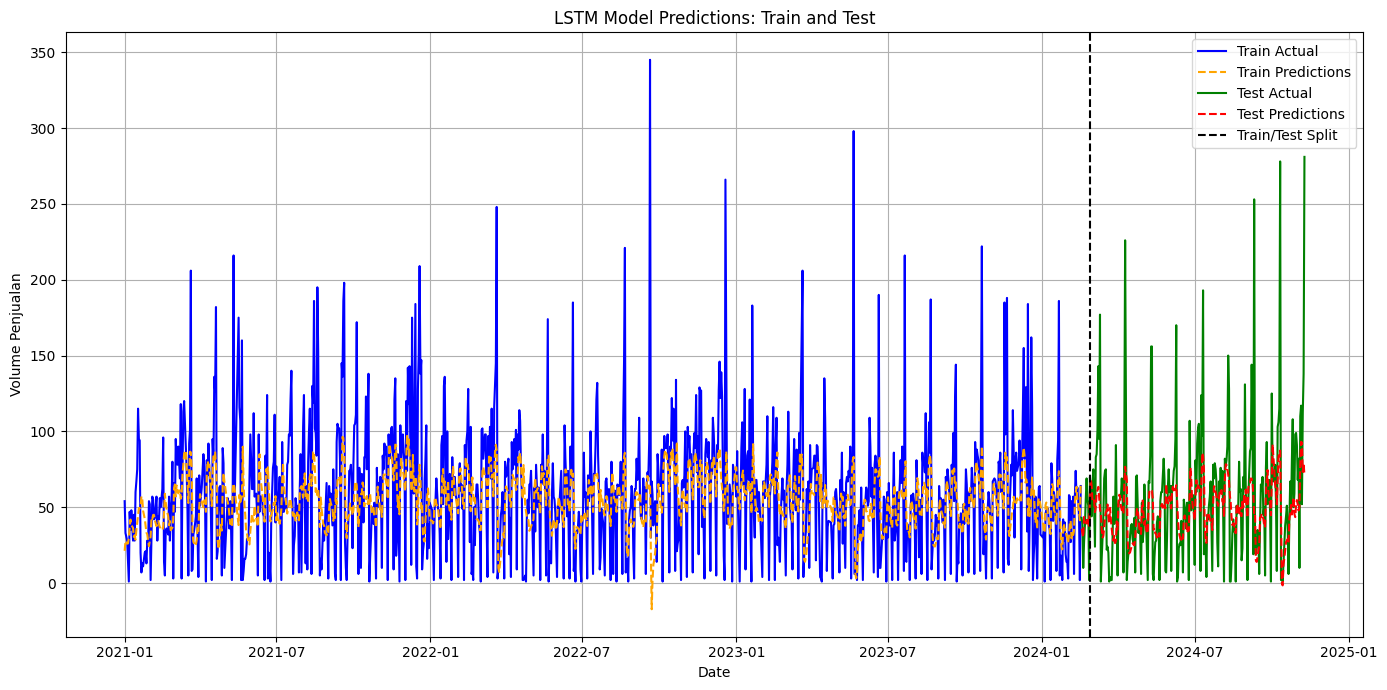

In [21]:
# Plot train and test results
plt.figure(figsize=(14, 7))
plt.plot(df.index[:len(y_train)], scaler.inverse_transform(y_train), label='Train Actual', color='blue')
plt.plot(df.index[:len(y_train)], train_predictions, label='Train Predictions', color='orange', linestyle='--')
plt.plot(df.index[len(y_train):len(y_train)+len(y_test)], scaler.inverse_transform(y_test), label='Test Actual', color='green')
plt.plot(df.index[len(y_train):len(y_train)+len(y_test)], test_predictions, label='Test Predictions', color='red', linestyle='--')
plt.axvline(x=df.index[train_size], color='black', linestyle='--', label='Train/Test Split')
plt.title('LSTM Model Predictions: Train and Test')
plt.xlabel('Date')
plt.ylabel('Volume Penjualan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# Forecast the next 30 days
forecast_input = scaled_values[-time_steps:]
forecast_predictions = []
for _ in range(30):
    forecast_data = forecast_input.reshape(1, time_steps, 1)
    prediction = best_model.predict(forecast_data)
    forecast_predictions.append(prediction[0, 0])
    forecast_input = np.append(forecast_input[1:], prediction, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [23]:
# Inverse transform the forecast predictions
forecast_predictions = scaler.inverse_transform(np.array(forecast_predictions).reshape(-1, 1))
forecast_predictions = np.maximum(forecast_predictions, 0)

In [24]:
# Create a DataFrame for forecast results
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Volume': forecast_predictions.flatten()})

# Display forecast results
print("\n30-Day Forecast:")
print(forecast_df)
forecast_df.to_csv('forecast_results.csv', index=False)


30-Day Forecast:
         Date  Forecasted Volume
0  2024-12-01          33.369194
1  2024-12-02           0.000000
2  2024-12-03           2.235295
3  2024-12-04          12.508621
4  2024-12-05          19.563538
5  2024-12-06          22.267473
6  2024-12-07          23.177721
7  2024-12-08          26.214979
8  2024-12-09          23.971827
9  2024-12-10          22.095371
10 2024-12-11          23.643114
11 2024-12-12          24.091349
12 2024-12-13          24.504984
13 2024-12-14          23.626816
14 2024-12-15          22.753571
15 2024-12-16          22.318268
16 2024-12-17          22.098469
17 2024-12-18          21.500677
18 2024-12-19          21.630241
19 2024-12-20          21.822189
20 2024-12-21          21.511988
21 2024-12-22          21.290203
22 2024-12-23          21.069510
23 2024-12-24          21.054941
24 2024-12-25          21.091101
25 2024-12-26          21.092690
26 2024-12-27          21.073532
27 2024-12-28          21.124771
28 2024-12-29          21

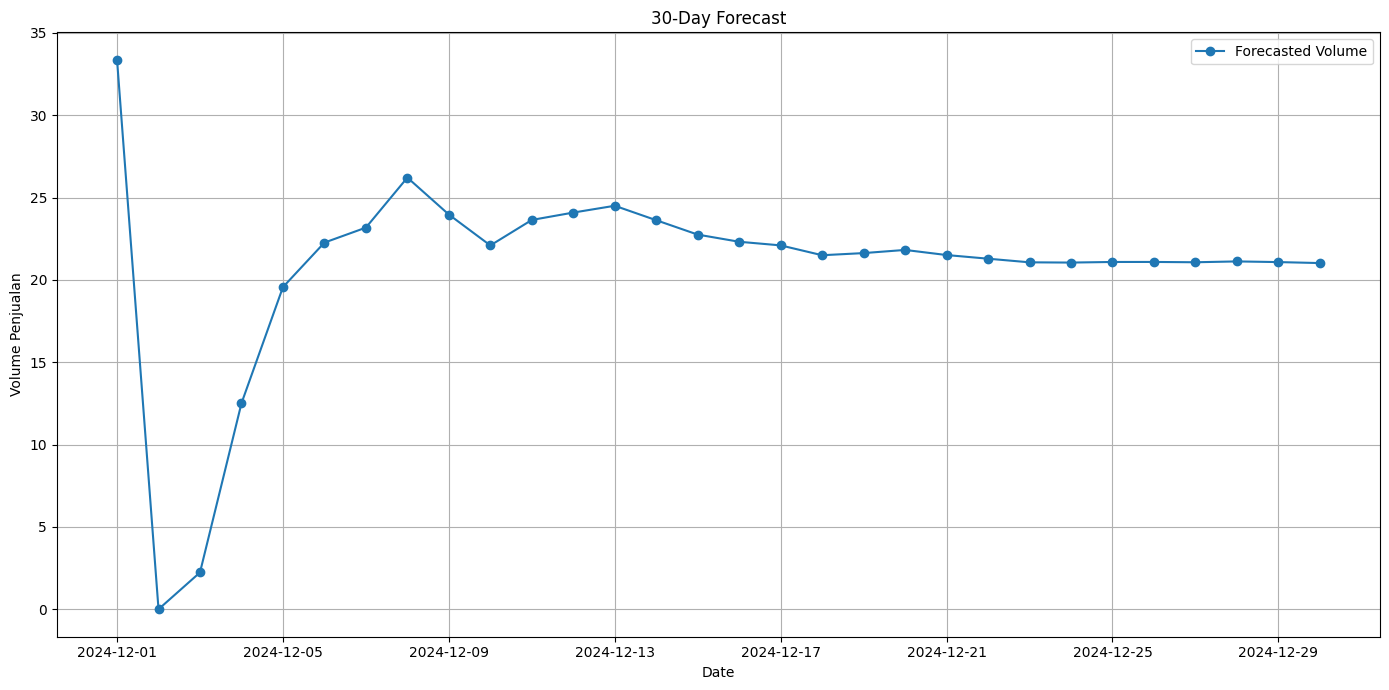

In [25]:
# Plot 30-day forecast
plt.figure(figsize=(14, 7))
plt.plot(forecast_df['Date'], forecast_df['Forecasted Volume'], marker='o', label='Forecasted Volume')
plt.title('30-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Volume Penjualan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

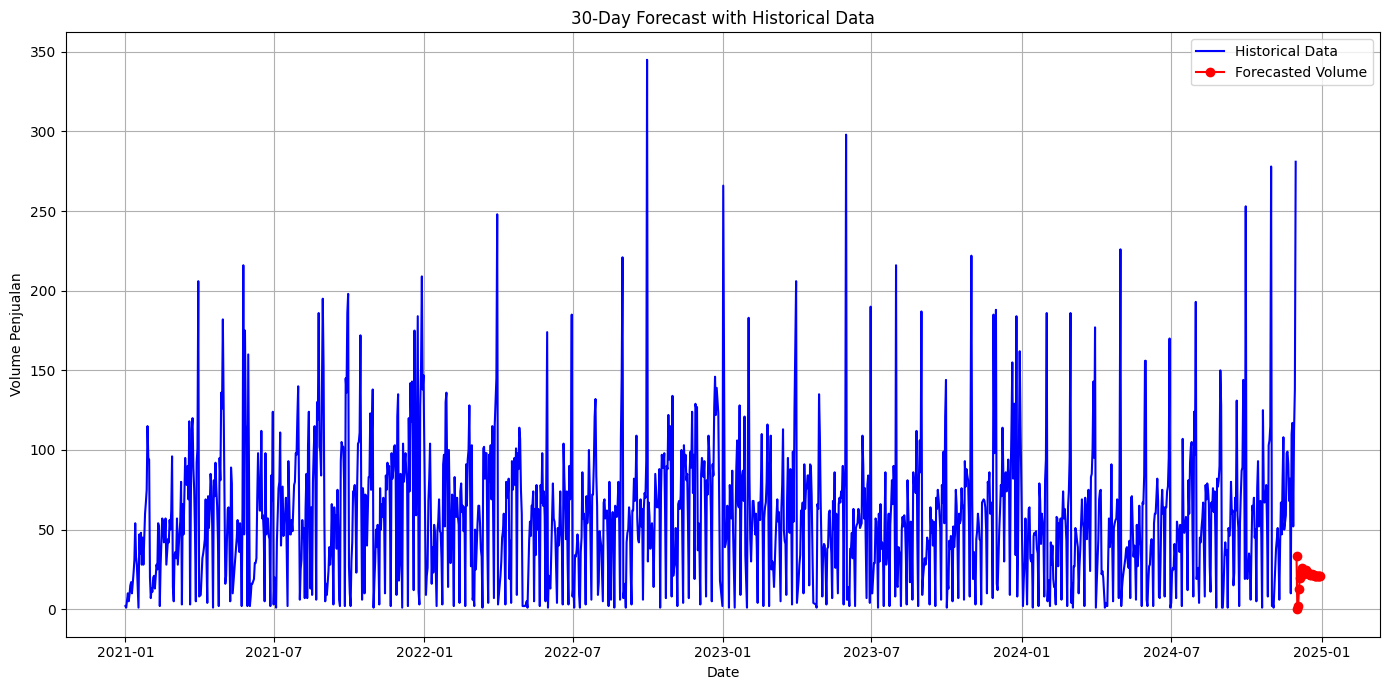

In [26]:
# Plot 30-day forecast with historical data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['volume penjualan'], label='Historical Data', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Forecasted Volume'], marker='o', label='Forecasted Volume', color='red')
plt.title('30-Day Forecast with Historical Data')
plt.xlabel('Date')
plt.ylabel('Volume Penjualan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
